In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib import cm, ticker
from matplotlib.colors import BoundaryNorm
from mpl_toolkits.mplot3d import Axes3D
import time

In [2]:
# Define the 2 population model and simulation

def SEIRV2PopModel(alpha_i1, alpha_i2, alpha_s1, alpha_s2, beta,
                           fv1, fv2, eA1, eA2, eL1, eL2, sigma1, sigma2, gamma1,
                           gamma2, tv, T, dt):
    def system(t, y):
        S1, S2, Vs1, Vs2, Vr1, Vr2, Ex1, Ex2, Inf1, Inf2, R1, R2 = y

        dS1_dt = -alpha_s1 * S1 * beta * (alpha_i1 * Inf1 + alpha_i2 * Inf2) - fv1 * np.heaviside(t - tv, 0) * S1
        dS2_dt = -alpha_s2 * S2 * beta * (alpha_i2 * Inf2 + alpha_i1 * Inf1) - fv2 * np.heaviside(t - tv, 0) * S2
        dVs1_dt = (1 - eA1) * fv1 * np.heaviside(t - tv, 0) * S1 - alpha_s1 * Vs1 * beta * (alpha_i1 * Inf1 + alpha_i2 * Inf2)
        dVs2_dt = (1 - eA2) * fv2 * np.heaviside(t - tv, 0) * S2 - alpha_s2 * Vs2 * beta * (alpha_i2 * Inf2 + alpha_i1 * Inf1)
        dVr1_dt = eA1 * fv1 * np.heaviside(t - tv, 0) * S1 - alpha_s1 * (1 - eL1) * Vr1 * beta * (alpha_i1 * Inf1 + alpha_i2 * Inf2)
        dVr2_dt = eA2 * fv2 * np.heaviside(t - tv, 0) * S2 - alpha_s2 * (1 - eL2) * Vr2 * beta * (alpha_i2 * Inf2 + alpha_i1 * Inf1)
        dEx1_dt = (S1 + Vs1 + (1 - eL1) * Vr1) * alpha_s1 * beta * (alpha_i1 * Inf1 + alpha_i2 * Inf2) - sigma1 * Ex1
        dEx2_dt = (S2 + Vs2 + (1 - eL2) * Vr2) * alpha_s2 * beta * (alpha_i1 * Inf1 + alpha_i2 * Inf2) - sigma2 * Ex2
        dInf1_dt = sigma1 * Ex1 - gamma1 * Inf1
        dInf2_dt = sigma2 * Ex2 - gamma2 * Inf2
        dR1_dt = gamma1 * Inf1
        dR2_dt = gamma2 * Inf2

        return [dS1_dt, dS2_dt, dVs1_dt, dVs2_dt, dVr1_dt, dVr2_dt, dEx1_dt, dEx2_dt, dInf1_dt, dInf2_dt, dR1_dt, dR2_dt]

    initial_conditions = [0.49, 0.49, 0, 0, 0, 0, 0.005, 0.005, 0.005, 0.005, 0, 0]
    t_span = (0, T)
    solution = solve_ivp(system, t_span, initial_conditions, method='RK45', dense_output=True)

    t_values = np.arange(0, T + dt, dt)
    R_values = solution.sol(t_values)[10]+ solution.sol(t_values)[11]
    Inf_values = solution.sol(t_values)[8] + solution.sol(t_values)[9]
    R1_values = solution.sol(t_values)[10]   
    R2_values = solution.sol(t_values)[11]

    output = [(t, R) for t, R in zip(t_values, R_values)], [(t, Inf) for t, Inf in zip(t_values, Inf_values)], [(t, R1_val) for t, R1_val in zip(t_values, R1_values)],[(t, R2_val) for t, R2_val in zip(t_values, R2_values)]
    return output

In [3]:
# Define a custom colormap plot such that positive and negative values have distinct colors

cmap = plt.get_cmap('PuOr')

# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

def plot_customcolorbar(val, x, y, m_list, vacc_eff, x_label, y_label, title, levels=False, bounds=np.zeros(1), plot_ref = False, save_fig = False, fig_name = 'example'):
    
    # Define the bins and normalize and forcing 0 to be part of the colorbar!
    # If bounds not provided by user, use min and max from the val array to set bounds
    
    if np.all(bounds==0):
        
        bounds = np.arange(np.min(val),np.max(val),0.01)
        
    else:
        
        idx=np.searchsorted(bounds,0)
        bounds=np.insert(bounds,idx,0)
    
    norm = BoundaryNorm(bounds, cmap.N)
    fig, ax = plt.subplots()
    # Just for the case where we have a few levels 
    if levels:
        cs = ax.contourf(1-x.transpose(), 1-y.transpose(), val, bounds, levels=[-1,-0.7,-0.3,-0.1,0.3,0.7,1], norm=norm, colors=['blue','red','red','blue','blue','blue'])
    else:
        cs = ax.contourf(1-x.transpose(), 1-y.transpose(), val, bounds, norm=norm, cmap=cmap)
    cbar = fig.colorbar(cs)
    if plot_ref:
        ax.plot((1-m_list),(1-m_list),'black',linestyle='dashed')

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xticks(ticks = [0,0.2,0.4,0.6,0.8,1], labels = [0,20,40,60,80,100])
    plt.yticks(ticks = [0,0.2,0.4,0.6,0.8,1], labels = [0,20,40,60,80,100])
    if save_fig:
        plt.savefig(fig_name, format='pdf', bbox_inches='tight')  

# Scenario 2: Group 2 has reduced severity and Group 1 has reduced susceptibility
## Scenario 2a (50% efficacy and 80% coverage)
### Keeping pre-vaccination R0 fixed

In [26]:
# Fixed variables 
# Assuming 80% of designated group receives vaccine that is only 50% efficacious 

start = time.time()

fv1 = 0.8
fv2 = 0.8
eA1 = 0.5
eA2 = 0.5
eL1 = 0.5
eL2 = 0.5
sigma1 = 0.25
sigma2 = 0.25
gamma1 = 0.25
gamma2 = 0.25
tv = 1.0
T = 200.0
dt = 0.1
per_severe = 0.01 # % infections that become severe at baseline

# Variables that will be looped over

R0_baseline_list = np.array([1.5,2,3]) # Vary beta to ensure this stays true
m_list = np.array([1]) # No reduction in infectiousness of Group 2
severe_red = np.linspace(0.001,1.00,1000) # Reduction in severity for Group 2
n_list = np.linspace(0.001,1.00,1000) # Reduction in susceptibility of Group 1 

# Save final epidemic sizes. leaky_1 means iteration where leaky vaccine was used to vaccinate group 1 etc

epi_size_leaky_1 = np.zeros((len(R0_baseline_list),len(m_list),len(n_list)))
epi_size_leaky_2 = np.zeros((len(R0_baseline_list),len(m_list),len(n_list)))
epi_size_AON_1 = np.zeros((len(R0_baseline_list),len(m_list),len(n_list)))
epi_size_AON_2 = np.zeros((len(R0_baseline_list),len(m_list),len(n_list)))
epi_size_no_vax = np.zeros((len(R0_baseline_list),len(m_list),len(n_list)))

severe_size_leaky_1 = np.zeros((len(R0_baseline_list),len(severe_red),len(n_list)))
severe_size_leaky_2 = np.zeros((len(R0_baseline_list),len(severe_red),len(n_list)))
severe_size_AON_1 = np.zeros((len(R0_baseline_list),len(severe_red),len(n_list)))
severe_size_AON_2 = np.zeros((len(R0_baseline_list),len(severe_red),len(n_list)))
severe_size_no_vax = np.zeros((len(R0_baseline_list),len(severe_red),len(n_list)))


for indx_R0 in range(len(R0_baseline_list)):
    
    R0 = R0_baseline_list[indx_R0]   
    for indx_m in range(len(m_list)):
        for indx_n in range(len(n_list)):
            
            alpha_i1 = 1
            alpha_s2 = 1          
            alpha_i2 = m_list[indx_m] 
            alpha_s1 = n_list[indx_n]
            
            beta = (R0*2*gamma1)/(n_list[indx_n]+m_list[indx_m])
            
            # Solve the system of ODEs
            
            leaky1_output = SEIRV2PopModel(alpha_i1, alpha_i2, alpha_s1, alpha_s2, beta,
                                fv1, 0, 1, 1, eL1, eL2, sigma1, sigma2, gamma1,
                                gamma2, tv, T, dt)
            leaky2_output = SEIRV2PopModel(alpha_i1, alpha_i2, alpha_s1, alpha_s2, beta,
                                0, fv2, 1, 1, eL1, eL2, sigma1, sigma2, gamma1,
                                gamma2, tv, T, dt)
            AON1_output = SEIRV2PopModel(alpha_i1, alpha_i2, alpha_s1, alpha_s2, beta,
                                fv1, 0, eA1, eA2, 1, 1, sigma1, sigma2, gamma1,
                                gamma2, tv, T, dt)
            AON2_output = SEIRV2PopModel(alpha_i1, alpha_i2, alpha_s1, alpha_s2, beta,
                                0, fv2, eA1, eA2, 1, 1, sigma1, sigma2, gamma1,
                                gamma2, tv, T, dt)
            no_vax_output = SEIRV2PopModel(alpha_i1, alpha_i2, alpha_s1, alpha_s2, beta,
                                0, 0, 1, 1, 1, 1, sigma1, sigma2, gamma1,
                                gamma2, tv, T, dt)
            
            
            # Save the total epidemic results 
            
            epi_size_leaky_1[indx_R0, indx_m, indx_n] = leaky1_output[0][-1][1]
            epi_size_leaky_2[indx_R0, indx_m, indx_n] = leaky2_output[0][-1][1]
            epi_size_AON_1[indx_R0, indx_m, indx_n] = AON1_output[0][-1][1]
            epi_size_AON_2[indx_R0, indx_m, indx_n] = AON2_output[0][-1][1]
            epi_size_no_vax[indx_R0, indx_m, indx_n] = no_vax_output[0][-1][1]
            
            # Save the severe infection results
            
            for indx_severe in range(len(severe_red)):
                
                severe_size_leaky_1[indx_R0, indx_severe, indx_n] = per_severe * (leaky1_output[2][-1][1]+leaky1_output[3][-1][1] * severe_red[indx_severe])
                severe_size_leaky_2[indx_R0, indx_severe, indx_n] = per_severe * (leaky2_output[2][-1][1] + leaky2_output[3][-1][1] * severe_red[indx_severe])
                severe_size_AON_1[indx_R0, indx_severe, indx_n] = per_severe * (AON1_output[2][-1][1] + AON1_output[3][-1][1] * severe_red[indx_severe])
                severe_size_AON_2[indx_R0, indx_severe, indx_n] = per_severe * (AON2_output[2][-1][1] + AON2_output[3][-1][1] * severe_red[indx_severe])
                severe_size_no_vax[indx_R0, indx_severe, indx_n] = per_severe * (no_vax_output[2][-1][1]+no_vax_output[3][-1][1] * severe_red[indx_severe])
                
end = time.time()
print(end - start)           

428.8665750026703


#### R0 = 1.5

In [27]:
X, Y = np.meshgrid(severe_red, n_list)

indx = 0

# Difference in relative reduction in # infected between vaccinating group 2 and group 1 as compared to the no vax case
Z1 = (severe_size_leaky_1[indx,:,:] - severe_size_leaky_2[indx,:,:])/severe_size_no_vax[indx,:,:]

Z2 = (severe_size_AON_1[indx,:,:] - severe_size_AON_2[indx,:,:])/severe_size_no_vax[indx,:,:]

# Difference in relative reduction in # infected between vaccinating group 1 across the two strategies. (AON-leaky)
Z3 = (severe_size_leaky_1[indx,:,:] - severe_size_AON_1[indx,:,:])/severe_size_no_vax[indx,:,:]

# Difference in relative reduction in # infected between vaccinating group 2 across the two strategies. (AON-leaky)
Z4= (severe_size_leaky_2[indx,:,:] - severe_size_AON_2[indx,:,:])/severe_size_no_vax[indx,:,:]

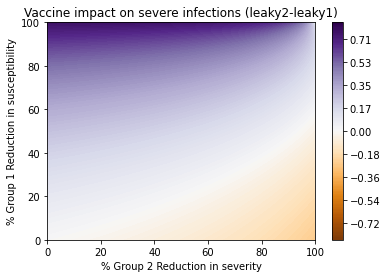

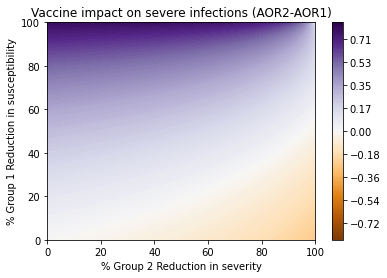

In [28]:
# Defining custom bounds such that we can compare between the two color maps
bounds = np.arange(-0.85,0.85,0.01)

plot_customcolorbar(Z1,X,Y,severe_red,1,'% Group 2 Reduction in severity','% Group 1 Reduction in susceptibility','Vaccine impact on severe infections (leaky2-leaky1)',bounds=bounds, save_fig = True, fig_name = 'Scenario2a_R01_5_vacimpact_leaky.pdf')
plot_customcolorbar(Z2,X,Y,severe_red,1,'% Group 2 Reduction in severity','% Group 1 Reduction in susceptibility','Vaccine impact on severe infections (AON2-AON1)',bounds=bounds, save_fig = True, fig_name = 'Scenario2a_R01_5_vacimpact_AON.pdf')

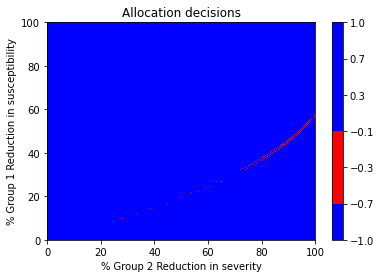

In [29]:
# Identifiying parameter space where the difference between the two decisions is highlighted

Z1_decisions = Z1.copy()
Z2_decisions = Z2.copy()

threshold_diff = 0.01 # Threshold for vaccine impact under which it doesn't matter which group is vaccinated. 

vax_2_leaky=np.where(Z1_decisions>threshold_diff)
vax_1_leaky=np.where(Z1_decisions<-threshold_diff)
vax_same_leaky_2 = np.where((Z1_decisions>=0)&(Z1_decisions<=threshold_diff))
vax_same_leaky_1 = np.where((Z1_decisions>=-threshold_diff)&(Z1_decisions<0))

vax_2_AON=np.where(Z2_decisions>threshold_diff)
vax_1_AON=np.where(Z2_decisions<-threshold_diff)
vax_same_AON_2 = np.where((Z2_decisions>=0)&(Z2_decisions<=threshold_diff))
vax_same_AON_1 = np.where((Z2_decisions>=-threshold_diff)&(Z2_decisions<0))

Z1_decisions[vax_2_leaky] = 1
Z1_decisions[vax_1_leaky] = -1
Z1_decisions[vax_same_leaky_2] = 2
Z1_decisions[vax_same_leaky_1] = -2

Z2_decisions[vax_2_AON] = 1
Z2_decisions[vax_1_AON] = -1
Z2_decisions[vax_same_AON_2] = 2
Z2_decisions[vax_same_AON_1] = -2

diff_decisions = (Z1_decisions * Z2_decisions)/4

bounds = np.arange(-1,1,0.01)
plot_customcolorbar(diff_decisions,X,Y,m_list,1,'% Group 2 Reduction in severity','% Group 1 Reduction in susceptibility','Allocation decisions',levels=True,bounds=bounds, save_fig = True, fig_name = 'Scenario2a_R01_5_diff.pdf')

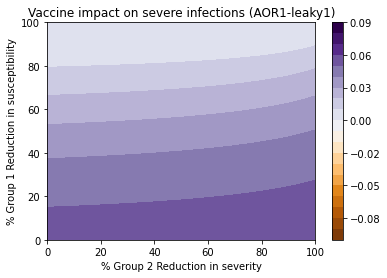

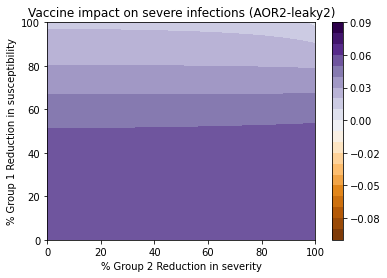

In [30]:
# How wrong the estimated impact will be depending upon which group is vaccinated for the two modes of failure

bounds = np.arange(-0.1,0.1,0.01)

plot_customcolorbar(Z3,X,Y,severe_red,1,'% Group 2 Reduction in severity','% Group 1 Reduction in susceptibility','Vaccine impact on severe infections (AON1-leaky1)',bounds=bounds, save_fig = True, fig_name = 'Scenario2a_R01_5_epi_diff_1.pdf')
plot_customcolorbar(Z4,X,Y,severe_red,1,'% Group 2 Reduction in severity','% Group 1 Reduction in susceptibility','Vaccine impact on severe infections (AON2-leaky2)',bounds=bounds, save_fig = True, fig_name = 'Scenario2a_R01_5_epi_diff_2.pdf')

#### R0 = 2

In [31]:
X, Y = np.meshgrid(severe_red, n_list)

indx = 1

# Difference in relative reduction in # infected between vaccinating group 2 and group 1 as compared to the no vax case
Z1 = (severe_size_leaky_1[indx,:,:] - severe_size_leaky_2[indx,:,:])/severe_size_no_vax[indx,:,:]

Z2 = (severe_size_AON_1[indx,:,:] - severe_size_AON_2[indx,:,:])/severe_size_no_vax[indx,:,:]

# Difference in relative reduction in # infected between vaccinating group 1 across the two strategies. (AON-leaky)
Z3 = (severe_size_leaky_1[indx,:,:] - severe_size_AON_1[indx,:,:])/severe_size_no_vax[indx,:,:]

# Difference in relative reduction in # infected between vaccinating group 2 across the two strategies. (AON-leaky)
Z4= (severe_size_leaky_2[indx,:,:] - severe_size_AON_2[indx,:,:])/severe_size_no_vax[indx,:,:]

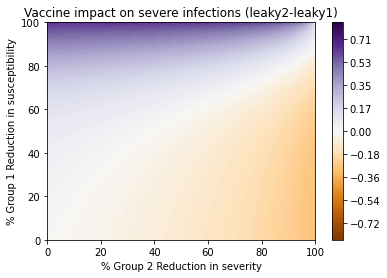

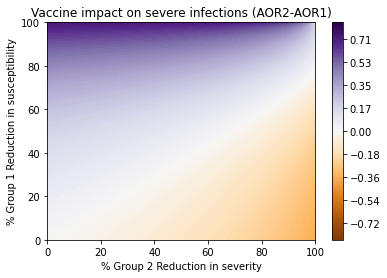

In [32]:
# Defining custom bounds such that we can compare between the two color maps
bounds = np.arange(-0.85,0.85,0.01)

plot_customcolorbar(Z1,X,Y,severe_red,1,'% Group 2 Reduction in severity','% Group 1 Reduction in susceptibility','Vaccine impact on severe infections (leaky2-leaky1)',bounds=bounds, save_fig = True, fig_name = 'Scenario2a_R02_vacimpact_leaky.pdf')
plot_customcolorbar(Z2,X,Y,severe_red,1,'% Group 2 Reduction in severity','% Group 1 Reduction in susceptibility','Vaccine impact on severe infections (AON2-AON1)',bounds=bounds, save_fig = True, fig_name = 'Scenario2a_R02_vacimpact_AON.pdf')

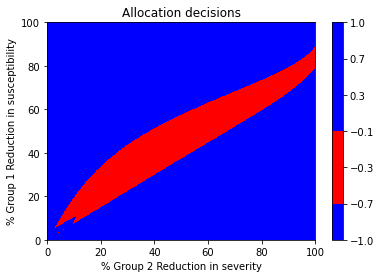

In [33]:
# Identifiying parameter space where the difference between the two decisions is highlighted

Z1_decisions = Z1.copy()
Z2_decisions = Z2.copy()

threshold_diff = 0.01 # Threshold for vaccine impact under which it doesn't matter which group is vaccinated. 

vax_2_leaky=np.where(Z1_decisions>threshold_diff)
vax_1_leaky=np.where(Z1_decisions<-threshold_diff)
vax_same_leaky_2 = np.where((Z1_decisions>=0)&(Z1_decisions<=threshold_diff))
vax_same_leaky_1 = np.where((Z1_decisions>=-threshold_diff)&(Z1_decisions<0))

vax_2_AON=np.where(Z2_decisions>threshold_diff)
vax_1_AON=np.where(Z2_decisions<-threshold_diff)
vax_same_AON_2 = np.where((Z2_decisions>=0)&(Z2_decisions<=threshold_diff))
vax_same_AON_1 = np.where((Z2_decisions>=-threshold_diff)&(Z2_decisions<0))

Z1_decisions[vax_2_leaky] = 1
Z1_decisions[vax_1_leaky] = -1
Z1_decisions[vax_same_leaky_2] = 2
Z1_decisions[vax_same_leaky_1] = -2

Z2_decisions[vax_2_AON] = 1
Z2_decisions[vax_1_AON] = -1
Z2_decisions[vax_same_AON_2] = 2
Z2_decisions[vax_same_AON_1] = -2

diff_decisions = (Z1_decisions * Z2_decisions)/4

bounds = np.arange(-1,1,0.01)
plot_customcolorbar(diff_decisions,X,Y,m_list,1,'% Group 2 Reduction in severity','% Group 1 Reduction in susceptibility','Allocation decisions',levels=True,bounds=bounds, save_fig = True, fig_name = 'Scenario2a_R02_diff.pdf')

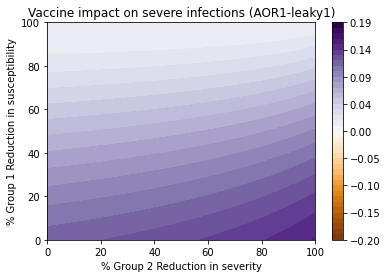

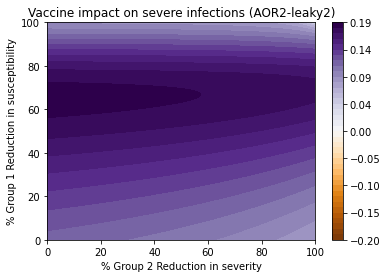

In [34]:
# How wrong the estimated impact will be depending upon which group is vaccinated for the two modes of failure

bounds = np.arange(-0.2,0.2,0.01)

plot_customcolorbar(Z3,X,Y,severe_red,1,'% Group 2 Reduction in severity','% Group 1 Reduction in susceptibility','Vaccine impact on severe infections (AON1-leaky1)',bounds=bounds, save_fig = True, fig_name = 'Scenario2a_R02_epi_diff_1.pdf')
plot_customcolorbar(Z4,X,Y,severe_red,1,'% Group 2 Reduction in severity','% Group 1 Reduction in susceptibility','Vaccine impact on severe infections (AON2-leaky2)',bounds=bounds, save_fig = True, fig_name = 'Scenario2a_R02_epi_diff_2.pdf')

#### R0 = 3

In [35]:
X, Y = np.meshgrid(severe_red, n_list)

indx = 2

# Difference in relative reduction in # infected between vaccinating group 2 and group 1 as compared to the no vax case
Z1 = (severe_size_leaky_1[indx,:,:] - severe_size_leaky_2[indx,:,:])/severe_size_no_vax[indx,:,:]

Z2 = (severe_size_AON_1[indx,:,:] - severe_size_AON_2[indx,:,:])/severe_size_no_vax[indx,:,:]

# Difference in relative reduction in # infected between vaccinating group 1 across the two strategies. (AON-leaky)
Z3 = (severe_size_leaky_1[indx,:,:] - severe_size_AON_1[indx,:,:])/severe_size_no_vax[indx,:,:]

# Difference in relative reduction in # infected between vaccinating group 2 across the two strategies. (AON-leaky)
Z4= (severe_size_leaky_2[indx,:,:] - severe_size_AON_2[indx,:,:])/severe_size_no_vax[indx,:,:]

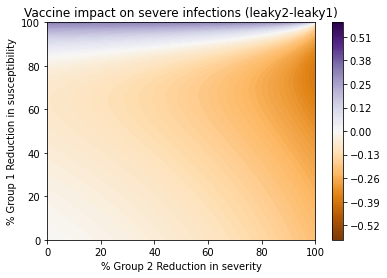

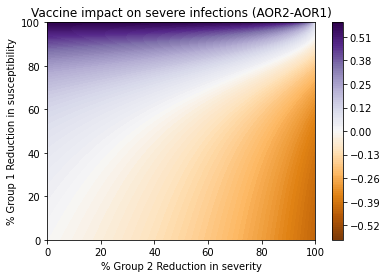

In [36]:
# Defining custom bounds such that we can compare between the two color maps
bounds = np.arange(-0.6,0.6,0.01)

plot_customcolorbar(Z1,X,Y,severe_red,1,'% Group 2 Reduction in severity','% Group 1 Reduction in susceptibility','Vaccine impact on severe infections (leaky2-leaky1)',bounds=bounds, save_fig = True, fig_name = 'Scenario2a_R03_vacimpact_leaky.pdf')
plot_customcolorbar(Z2,X,Y,severe_red,1,'% Group 2 Reduction in severity','% Group 1 Reduction in susceptibility','Vaccine impact on severe infections (AON2-AON1)',bounds=bounds, save_fig = True, fig_name = 'Scenario2a_R03_vacimpact_AON.pdf')

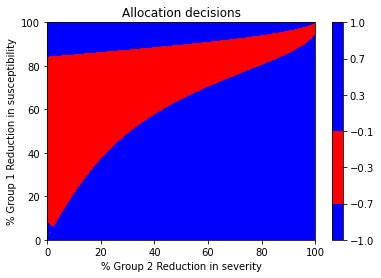

In [37]:
# Identifiying parameter space where the difference between the two decisions is highlighted

Z1_decisions = Z1.copy()
Z2_decisions = Z2.copy()

threshold_diff = 0.01 # Threshold for vaccine impact under which it doesn't matter which group is vaccinated. 

vax_2_leaky=np.where(Z1_decisions>threshold_diff)
vax_1_leaky=np.where(Z1_decisions<-threshold_diff)
vax_same_leaky_2 = np.where((Z1_decisions>=0)&(Z1_decisions<=threshold_diff))
vax_same_leaky_1 = np.where((Z1_decisions>=-threshold_diff)&(Z1_decisions<0))

vax_2_AON=np.where(Z2_decisions>threshold_diff)
vax_1_AON=np.where(Z2_decisions<-threshold_diff)
vax_same_AON_2 = np.where((Z2_decisions>=0)&(Z2_decisions<=threshold_diff))
vax_same_AON_1 = np.where((Z2_decisions>=-threshold_diff)&(Z2_decisions<0))

Z1_decisions[vax_2_leaky] = 1
Z1_decisions[vax_1_leaky] = -1
Z1_decisions[vax_same_leaky_2] = 2
Z1_decisions[vax_same_leaky_1] = -2

Z2_decisions[vax_2_AON] = 1
Z2_decisions[vax_1_AON] = -1
Z2_decisions[vax_same_AON_2] = 2
Z2_decisions[vax_same_AON_1] = -2

diff_decisions = (Z1_decisions * Z2_decisions)/4

bounds = np.arange(-1,1,0.01)
plot_customcolorbar(diff_decisions,X,Y,m_list,1,'% Group 2 Reduction in severity','% Group 1 Reduction in susceptibility','Allocation decisions',levels=True,bounds=bounds, save_fig = True, fig_name = 'Scenario2a_R03_diff.pdf')

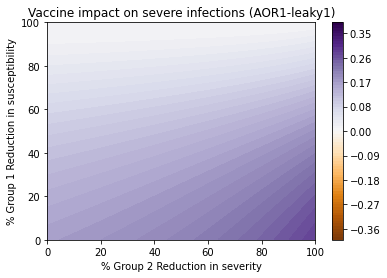

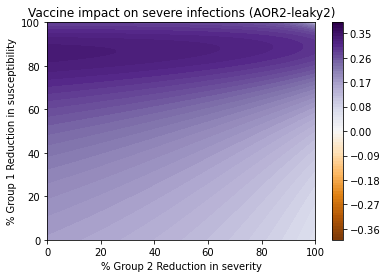

In [38]:
bounds = np.arange(-0.4,0.4,0.01)

plot_customcolorbar(Z3,X,Y,severe_red,1,'% Group 2 Reduction in severity','% Group 1 Reduction in susceptibility','Vaccine impact on severe infections (AON1-leaky1)',bounds=bounds, save_fig = True, fig_name = 'Scenario2a_R03_epi_diff_1.pdf')
plot_customcolorbar(Z4,X,Y,severe_red,1,'% Group 2 Reduction in severity','% Group 1 Reduction in susceptibility','Vaccine impact on severe infections (AON2-leaky2)',bounds=bounds, save_fig = True, fig_name = 'Scenario2a_R03_epi_diff_2.pdf')

# Scenario 2: Group 2 has reduced severity and Group 1 has reduced susceptibility
## Scenario 2b (80% efficacy and 80% coverage)
### Keeping pre-vaccination R0 fixed

In [39]:
# Fixed variables 
# Assuming 80% of designated group receives vaccine that is 80% efficacious 

start = time.time()

fv1 = 0.8
fv2 = 0.8
eA1 = 0.8
eA2 = 0.8
eL1 = 0.8
eL2 = 0.8
sigma1 = 0.25
sigma2 = 0.25
gamma1 = 0.25
gamma2 = 0.25
tv = 1.0
T = 200.0
dt = 0.1
per_severe = 0.01 # % infections that become severe at baseline

# Variables that will be looped over

R0_baseline_list = np.array([1.5,2,3]) # Vary beta to ensure this stays true
m_list = np.array([1]) # No reduction in infectiousness of Group 2
severe_red = np.linspace(0.001,1.00,1000) # Reduction in severity for Group 2
n_list = np.linspace(0.001,1.00,1000) # Reduction in susceptibility of Group 1 

# Save final epidemic sizes. leaky_1 means iteration where leaky vaccine was used to vaccinate group 1 etc

epi_size_leaky_1 = np.zeros((len(R0_baseline_list),len(m_list),len(n_list)))
epi_size_leaky_2 = np.zeros((len(R0_baseline_list),len(m_list),len(n_list)))
epi_size_AON_1 = np.zeros((len(R0_baseline_list),len(m_list),len(n_list)))
epi_size_AON_2 = np.zeros((len(R0_baseline_list),len(m_list),len(n_list)))
epi_size_no_vax = np.zeros((len(R0_baseline_list),len(m_list),len(n_list)))

severe_size_leaky_1 = np.zeros((len(R0_baseline_list),len(severe_red),len(n_list)))
severe_size_leaky_2 = np.zeros((len(R0_baseline_list),len(severe_red),len(n_list)))
severe_size_AON_1 = np.zeros((len(R0_baseline_list),len(severe_red),len(n_list)))
severe_size_AON_2 = np.zeros((len(R0_baseline_list),len(severe_red),len(n_list)))
severe_size_no_vax = np.zeros((len(R0_baseline_list),len(severe_red),len(n_list)))


for indx_R0 in range(len(R0_baseline_list)):
    
    R0 = R0_baseline_list[indx_R0]   
    for indx_m in range(len(m_list)):
        for indx_n in range(len(n_list)):
            
            alpha_i1 = 1
            alpha_s2 = 1          
            alpha_i2 = m_list[indx_m] 
            alpha_s1 = n_list[indx_n]
            
            beta = (R0*2*gamma1)/(n_list[indx_n]+m_list[indx_m])
            
            # Solve the system of ODEs
            
            leaky1_output = SEIRV2PopModel(alpha_i1, alpha_i2, alpha_s1, alpha_s2, beta,
                                fv1, 0, 1, 1, eL1, eL2, sigma1, sigma2, gamma1,
                                gamma2, tv, T, dt)
            leaky2_output = SEIRV2PopModel(alpha_i1, alpha_i2, alpha_s1, alpha_s2, beta,
                                0, fv2, 1, 1, eL1, eL2, sigma1, sigma2, gamma1,
                                gamma2, tv, T, dt)
            AON1_output = SEIRV2PopModel(alpha_i1, alpha_i2, alpha_s1, alpha_s2, beta,
                                fv1, 0, eA1, eA2, 1, 1, sigma1, sigma2, gamma1,
                                gamma2, tv, T, dt)
            AON2_output = SEIRV2PopModel(alpha_i1, alpha_i2, alpha_s1, alpha_s2, beta,
                                0, fv2, eA1, eA2, 1, 1, sigma1, sigma2, gamma1,
                                gamma2, tv, T, dt)
            no_vax_output = SEIRV2PopModel(alpha_i1, alpha_i2, alpha_s1, alpha_s2, beta,
                                0, 0, 1, 1, 1, 1, sigma1, sigma2, gamma1,
                                gamma2, tv, T, dt)
            
            
            # Save the total epidemic results 
            
            epi_size_leaky_1[indx_R0, indx_m, indx_n] = leaky1_output[0][-1][1]
            epi_size_leaky_2[indx_R0, indx_m, indx_n] = leaky2_output[0][-1][1]
            epi_size_AON_1[indx_R0, indx_m, indx_n] = AON1_output[0][-1][1]
            epi_size_AON_2[indx_R0, indx_m, indx_n] = AON2_output[0][-1][1]
            epi_size_no_vax[indx_R0, indx_m, indx_n] = no_vax_output[0][-1][1]
            
            # Save the severe infection results
            
            for indx_severe in range(len(severe_red)):
                
                severe_size_leaky_1[indx_R0, indx_severe, indx_n] = per_severe * (leaky1_output[2][-1][1]+leaky1_output[3][-1][1] * severe_red[indx_severe])
                severe_size_leaky_2[indx_R0, indx_severe, indx_n] = per_severe * (leaky2_output[2][-1][1] + leaky2_output[3][-1][1] * severe_red[indx_severe])
                severe_size_AON_1[indx_R0, indx_severe, indx_n] = per_severe * (AON1_output[2][-1][1] + AON1_output[3][-1][1] * severe_red[indx_severe])
                severe_size_AON_2[indx_R0, indx_severe, indx_n] = per_severe * (AON2_output[2][-1][1] + AON2_output[3][-1][1] * severe_red[indx_severe])
                severe_size_no_vax[indx_R0, indx_severe, indx_n] = per_severe * (no_vax_output[2][-1][1]+no_vax_output[3][-1][1] * severe_red[indx_severe])
                
end = time.time()
print(end - start)           

443.12519693374634


#### R0 = 1.5

In [54]:
X, Y = np.meshgrid(severe_red, n_list)

indx = 0

# Difference in relative reduction in # infected between vaccinating group 2 and group 1 as compared to the no vax case
Z1 = (severe_size_leaky_1[indx,:,:] - severe_size_leaky_2[indx,:,:])/severe_size_no_vax[indx,:,:]

Z2 = (severe_size_AON_1[indx,:,:] - severe_size_AON_2[indx,:,:])/severe_size_no_vax[indx,:,:]

# Difference in relative reduction in # infected between vaccinating group 1 across the two strategies. (AON-leaky)
Z3 = (severe_size_leaky_1[indx,:,:] - severe_size_AON_1[indx,:,:])/severe_size_no_vax[indx,:,:]

# Difference in relative reduction in # infected between vaccinating group 2 across the two strategies. (AON-leaky)
Z4= (severe_size_leaky_2[indx,:,:] - severe_size_AON_2[indx,:,:])/severe_size_no_vax[indx,:,:]

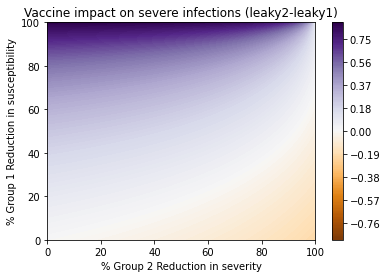

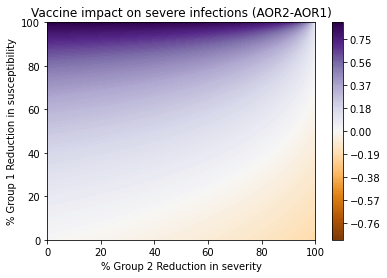

In [55]:
# Defining custom bounds such that we can compare between the two color maps
bounds = np.arange(-0.9,0.9,0.01)

plot_customcolorbar(Z1,X,Y,severe_red,1,'% Group 2 Reduction in severity','% Group 1 Reduction in susceptibility','Vaccine impact on severe infections (leaky2-leaky1)',bounds=bounds)
plot_customcolorbar(Z2,X,Y,severe_red,1,'% Group 2 Reduction in severity','% Group 1 Reduction in susceptibility','Vaccine impact on severe infections (AON2-AON1)',bounds=bounds)

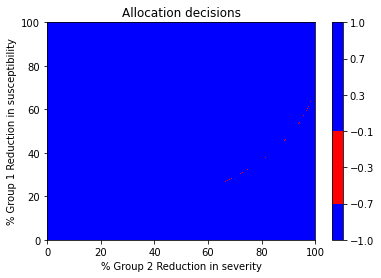

In [56]:
# Identifiying parameter space where the difference between the two decisions is highlighted

Z1_decisions = Z1.copy()
Z2_decisions = Z2.copy()

threshold_diff = 0.01 # Threshold for vaccine impact under which it doesn't matter which group is vaccinated. 

vax_2_leaky=np.where(Z1_decisions>threshold_diff)
vax_1_leaky=np.where(Z1_decisions<-threshold_diff)
vax_same_leaky_2 = np.where((Z1_decisions>=0)&(Z1_decisions<=threshold_diff))
vax_same_leaky_1 = np.where((Z1_decisions>=-threshold_diff)&(Z1_decisions<0))

vax_2_AON=np.where(Z2_decisions>threshold_diff)
vax_1_AON=np.where(Z2_decisions<-threshold_diff)
vax_same_AON_2 = np.where((Z2_decisions>=0)&(Z2_decisions<=threshold_diff))
vax_same_AON_1 = np.where((Z2_decisions>=-threshold_diff)&(Z2_decisions<0))

Z1_decisions[vax_2_leaky] = 1
Z1_decisions[vax_1_leaky] = -1
Z1_decisions[vax_same_leaky_2] = 2
Z1_decisions[vax_same_leaky_1] = -2

Z2_decisions[vax_2_AON] = 1
Z2_decisions[vax_1_AON] = -1
Z2_decisions[vax_same_AON_2] = 2
Z2_decisions[vax_same_AON_1] = -2

diff_decisions = (Z1_decisions * Z2_decisions)/4

bounds = np.arange(-1,1,0.01)
plot_customcolorbar(diff_decisions,X,Y,m_list,1,'% Group 2 Reduction in severity','% Group 1 Reduction in susceptibility','Allocation decisions',levels=True,bounds=bounds)

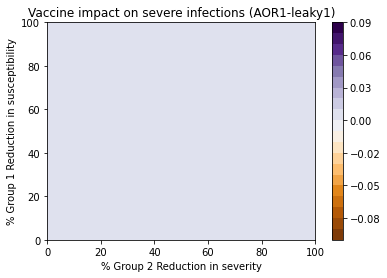

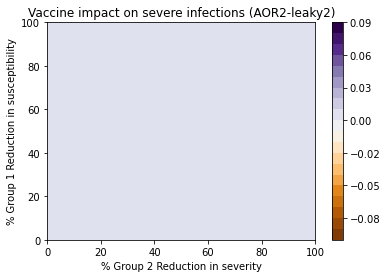

In [57]:
bounds = np.arange(-0.1,0.1,0.01)

plot_customcolorbar(Z3,X,Y,severe_red,1,'% Group 2 Reduction in severity','% Group 1 Reduction in susceptibility','Vaccine impact on severe infections (AON1-leaky1)',bounds=bounds)
plot_customcolorbar(Z4,X,Y,severe_red,1,'% Group 2 Reduction in severity','% Group 1 Reduction in susceptibility','Vaccine impact on severe infections (AON2-leaky2)',bounds=bounds)

#### R0 = 2

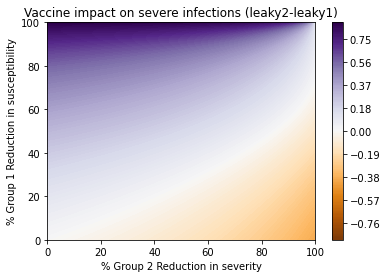

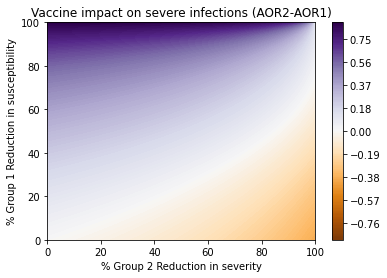

In [58]:
X, Y = np.meshgrid(severe_red, n_list)

indx = 1

# Difference in relative reduction in # infected between vaccinating group 2 and group 1 as compared to the no vax case
Z1 = (severe_size_leaky_1[indx,:,:] - severe_size_leaky_2[indx,:,:])/severe_size_no_vax[indx,:,:]

Z2 = (severe_size_AON_1[indx,:,:] - severe_size_AON_2[indx,:,:])/severe_size_no_vax[indx,:,:]

# Difference in relative reduction in # infected between vaccinating group 1 across the two strategies. (AON-leaky)
Z3 = (severe_size_leaky_1[indx,:,:] - severe_size_AON_1[indx,:,:])/severe_size_no_vax[indx,:,:]

# Difference in relative reduction in # infected between vaccinating group 2 across the two strategies. (AON-leaky)
Z4= (severe_size_leaky_2[indx,:,:] - severe_size_AON_2[indx,:,:])/severe_size_no_vax[indx,:,:]

# Defining custom bounds such that we can compare between the two color maps
bounds = np.arange(-0.9,0.9,0.01)

plot_customcolorbar(Z1,X,Y,severe_red,1,'% Group 2 Reduction in severity','% Group 1 Reduction in susceptibility','Vaccine impact on severe infections (leaky2-leaky1)',bounds=bounds)
plot_customcolorbar(Z2,X,Y,severe_red,1,'% Group 2 Reduction in severity','% Group 1 Reduction in susceptibility','Vaccine impact on severe infections (AON2-AON1)',bounds=bounds)

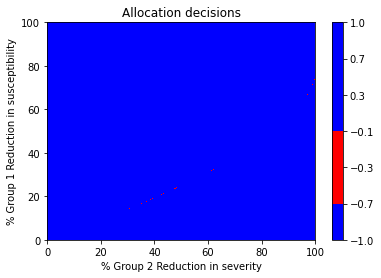

In [59]:
# Identifiying parameter space where the difference between the two decisions is highlighted

Z1_decisions = Z1.copy()
Z2_decisions = Z2.copy()

threshold_diff = 0.01 # Threshold for vaccine impact under which it doesn't matter which group is vaccinated. 

vax_2_leaky=np.where(Z1_decisions>threshold_diff)
vax_1_leaky=np.where(Z1_decisions<-threshold_diff)
vax_same_leaky_2 = np.where((Z1_decisions>=0)&(Z1_decisions<=threshold_diff))
vax_same_leaky_1 = np.where((Z1_decisions>=-threshold_diff)&(Z1_decisions<0))

vax_2_AON=np.where(Z2_decisions>threshold_diff)
vax_1_AON=np.where(Z2_decisions<-threshold_diff)
vax_same_AON_2 = np.where((Z2_decisions>=0)&(Z2_decisions<=threshold_diff))
vax_same_AON_1 = np.where((Z2_decisions>=-threshold_diff)&(Z2_decisions<0))

Z1_decisions[vax_2_leaky] = 1
Z1_decisions[vax_1_leaky] = -1
Z1_decisions[vax_same_leaky_2] = 2
Z1_decisions[vax_same_leaky_1] = -2

Z2_decisions[vax_2_AON] = 1
Z2_decisions[vax_1_AON] = -1
Z2_decisions[vax_same_AON_2] = 2
Z2_decisions[vax_same_AON_1] = -2

diff_decisions = (Z1_decisions * Z2_decisions)/4

bounds = np.arange(-1,1,0.01)
plot_customcolorbar(diff_decisions,X,Y,m_list,1,'% Group 2 Reduction in severity','% Group 1 Reduction in susceptibility','Allocation decisions',levels=True,bounds=bounds)

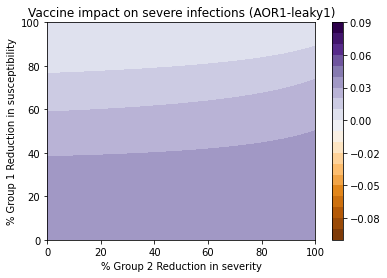

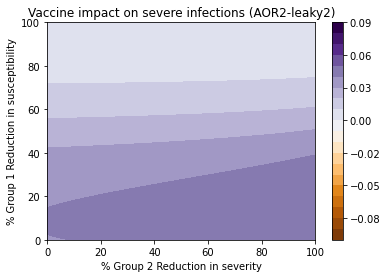

In [60]:
bounds = np.arange(-0.1,0.1,0.01)

plot_customcolorbar(Z3,X,Y,severe_red,1,'% Group 2 Reduction in severity','% Group 1 Reduction in susceptibility','Vaccine impact on severe infections (AON1-leaky1)',bounds=bounds)
plot_customcolorbar(Z4,X,Y,severe_red,1,'% Group 2 Reduction in severity','% Group 1 Reduction in susceptibility','Vaccine impact on severe infections (AON2-leaky2)',bounds=bounds)

#### R0 = 3

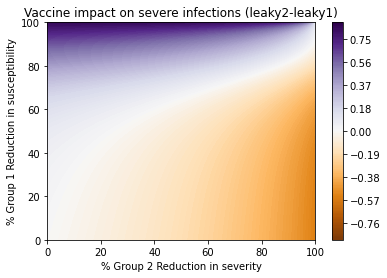

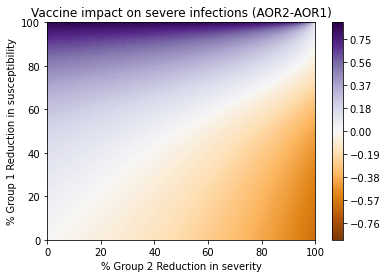

In [50]:
X, Y = np.meshgrid(severe_red, n_list)

indx = 2

# Difference in relative reduction in # infected between vaccinating group 2 and group 1 as compared to the no vax case
Z1 = (severe_size_leaky_1[indx,:,:] - severe_size_leaky_2[indx,:,:])/severe_size_no_vax[indx,:,:]

Z2 = (severe_size_AON_1[indx,:,:] - severe_size_AON_2[indx,:,:])/severe_size_no_vax[indx,:,:]

# Difference in relative reduction in # infected between vaccinating group 1 across the two strategies. (AON-leaky)
Z3 = (severe_size_leaky_1[indx,:,:] - severe_size_AON_1[indx,:,:])/severe_size_no_vax[indx,:,:]

# Difference in relative reduction in # infected between vaccinating group 2 across the two strategies. (AON-leaky)
Z4= (severe_size_leaky_2[indx,:,:] - severe_size_AON_2[indx,:,:])/severe_size_no_vax[indx,:,:]

# Defining custom bounds such that we can compare between the two color maps
bounds = np.arange(-0.9,0.9,0.01)

plot_customcolorbar(Z1,X,Y,severe_red,1,'% Group 2 Reduction in severity','% Group 1 Reduction in susceptibility','Vaccine impact on severe infections (leaky2-leaky1)',bounds=bounds)
plot_customcolorbar(Z2,X,Y,severe_red,1,'% Group 2 Reduction in severity','% Group 1 Reduction in susceptibility','Vaccine impact on severe infections (AON2-AON1)',bounds=bounds)

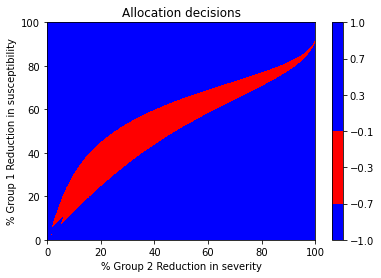

In [51]:
# Identifiying parameter space where the difference between the two decisions is highlighted

Z1_decisions = Z1.copy()
Z2_decisions = Z2.copy()

threshold_diff = 0.01 # Threshold for vaccine impact under which it doesn't matter which group is vaccinated. 

vax_2_leaky=np.where(Z1_decisions>threshold_diff)
vax_1_leaky=np.where(Z1_decisions<-threshold_diff)
vax_same_leaky_2 = np.where((Z1_decisions>=0)&(Z1_decisions<=threshold_diff))
vax_same_leaky_1 = np.where((Z1_decisions>=-threshold_diff)&(Z1_decisions<0))

vax_2_AON=np.where(Z2_decisions>threshold_diff)
vax_1_AON=np.where(Z2_decisions<-threshold_diff)
vax_same_AON_2 = np.where((Z2_decisions>=0)&(Z2_decisions<=threshold_diff))
vax_same_AON_1 = np.where((Z2_decisions>=-threshold_diff)&(Z2_decisions<0))

Z1_decisions[vax_2_leaky] = 1
Z1_decisions[vax_1_leaky] = -1
Z1_decisions[vax_same_leaky_2] = 2
Z1_decisions[vax_same_leaky_1] = -2

Z2_decisions[vax_2_AON] = 1
Z2_decisions[vax_1_AON] = -1
Z2_decisions[vax_same_AON_2] = 2
Z2_decisions[vax_same_AON_1] = -2

diff_decisions = (Z1_decisions * Z2_decisions)/4

bounds = np.arange(-1,1,0.01)
plot_customcolorbar(diff_decisions,X,Y,m_list,1,'% Group 2 Reduction in severity','% Group 1 Reduction in susceptibility','Allocation decisions',levels=True,bounds=bounds)

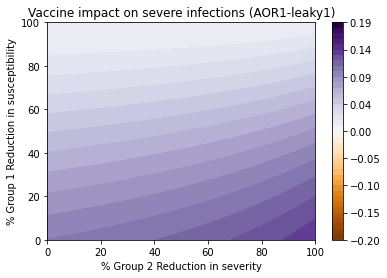

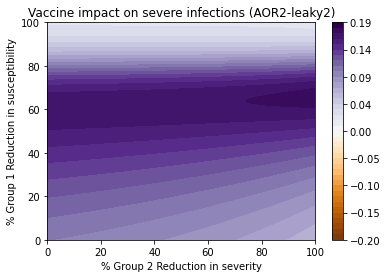

In [53]:
bounds = np.arange(-0.2,0.2,0.01)

plot_customcolorbar(Z3,X,Y,severe_red,1,'% Group 2 Reduction in severity','% Group 1 Reduction in susceptibility','Vaccine impact on severe infections (AON1-leaky1)',bounds=bounds)
plot_customcolorbar(Z4,X,Y,severe_red,1,'% Group 2 Reduction in severity','% Group 1 Reduction in susceptibility','Vaccine impact on severe infections (AON2-leaky2)',bounds=bounds)

# Scenario 2: Group 2 has reduced severity and Group 1 has reduced susceptibility
## Scenario 2c (80% efficacy and 50% coverage)
### Keeping pre-vaccination R0 fixed

In [4]:
# Fixed variables 
# Assuming 50% of designated group receives vaccine that is 80% efficacious 

start = time.time()

fv1 = 0.5
fv2 = 0.5
eA1 = 0.8
eA2 = 0.8
eL1 = 0.8
eL2 = 0.8
sigma1 = 0.25
sigma2 = 0.25
gamma1 = 0.25
gamma2 = 0.25
tv = 1.0
T = 200.0
dt = 0.1
per_severe = 0.01 # % infections that become severe at baseline

# Variables that will be looped over

R0_baseline_list = np.array([1.5,2,3]) # Vary beta to ensure this stays true
m_list = np.array([1]) # No reduction in infectiousness of Group 2
severe_red = np.linspace(0.001,1.00,1000) # Reduction in severity for Group 2
n_list = np.linspace(0.001,1.00,1000) # Reduction in susceptibility of Group 1 

# Save final epidemic sizes. leaky_1 means iteration where leaky vaccine was used to vaccinate group 1 etc

epi_size_leaky_1 = np.zeros((len(R0_baseline_list),len(m_list),len(n_list)))
epi_size_leaky_2 = np.zeros((len(R0_baseline_list),len(m_list),len(n_list)))
epi_size_AON_1 = np.zeros((len(R0_baseline_list),len(m_list),len(n_list)))
epi_size_AON_2 = np.zeros((len(R0_baseline_list),len(m_list),len(n_list)))
epi_size_no_vax = np.zeros((len(R0_baseline_list),len(m_list),len(n_list)))

severe_size_leaky_1 = np.zeros((len(R0_baseline_list),len(severe_red),len(n_list)))
severe_size_leaky_2 = np.zeros((len(R0_baseline_list),len(severe_red),len(n_list)))
severe_size_AON_1 = np.zeros((len(R0_baseline_list),len(severe_red),len(n_list)))
severe_size_AON_2 = np.zeros((len(R0_baseline_list),len(severe_red),len(n_list)))
severe_size_no_vax = np.zeros((len(R0_baseline_list),len(severe_red),len(n_list)))


for indx_R0 in range(len(R0_baseline_list)):
    
    R0 = R0_baseline_list[indx_R0]   
    for indx_m in range(len(m_list)):
        for indx_n in range(len(n_list)):
            
            alpha_i1 = 1
            alpha_s2 = 1          
            alpha_i2 = m_list[indx_m] 
            alpha_s1 = n_list[indx_n]
            
            beta = (R0*2*gamma1)/(n_list[indx_n]+m_list[indx_m])
            
            # Solve the system of ODEs
            
            leaky1_output = SEIRV2PopModel(alpha_i1, alpha_i2, alpha_s1, alpha_s2, beta,
                                fv1, 0, 1, 1, eL1, eL2, sigma1, sigma2, gamma1,
                                gamma2, tv, T, dt)
            leaky2_output = SEIRV2PopModel(alpha_i1, alpha_i2, alpha_s1, alpha_s2, beta,
                                0, fv2, 1, 1, eL1, eL2, sigma1, sigma2, gamma1,
                                gamma2, tv, T, dt)
            AON1_output = SEIRV2PopModel(alpha_i1, alpha_i2, alpha_s1, alpha_s2, beta,
                                fv1, 0, eA1, eA2, 1, 1, sigma1, sigma2, gamma1,
                                gamma2, tv, T, dt)
            AON2_output = SEIRV2PopModel(alpha_i1, alpha_i2, alpha_s1, alpha_s2, beta,
                                0, fv2, eA1, eA2, 1, 1, sigma1, sigma2, gamma1,
                                gamma2, tv, T, dt)
            no_vax_output = SEIRV2PopModel(alpha_i1, alpha_i2, alpha_s1, alpha_s2, beta,
                                0, 0, 1, 1, 1, 1, sigma1, sigma2, gamma1,
                                gamma2, tv, T, dt)
            
            
            # Save the total epidemic results 
            
            epi_size_leaky_1[indx_R0, indx_m, indx_n] = leaky1_output[0][-1][1]
            epi_size_leaky_2[indx_R0, indx_m, indx_n] = leaky2_output[0][-1][1]
            epi_size_AON_1[indx_R0, indx_m, indx_n] = AON1_output[0][-1][1]
            epi_size_AON_2[indx_R0, indx_m, indx_n] = AON2_output[0][-1][1]
            epi_size_no_vax[indx_R0, indx_m, indx_n] = no_vax_output[0][-1][1]
            
            # Save the severe infection results
            
            for indx_severe in range(len(severe_red)):
                
                severe_size_leaky_1[indx_R0, indx_severe, indx_n] = per_severe * (leaky1_output[2][-1][1]+leaky1_output[3][-1][1] * severe_red[indx_severe])
                severe_size_leaky_2[indx_R0, indx_severe, indx_n] = per_severe * (leaky2_output[2][-1][1] + leaky2_output[3][-1][1] * severe_red[indx_severe])
                severe_size_AON_1[indx_R0, indx_severe, indx_n] = per_severe * (AON1_output[2][-1][1] + AON1_output[3][-1][1] * severe_red[indx_severe])
                severe_size_AON_2[indx_R0, indx_severe, indx_n] = per_severe * (AON2_output[2][-1][1] + AON2_output[3][-1][1] * severe_red[indx_severe])
                severe_size_no_vax[indx_R0, indx_severe, indx_n] = per_severe * (no_vax_output[2][-1][1]+no_vax_output[3][-1][1] * severe_red[indx_severe])
                
end = time.time()
print(end - start)           

352.8371708393097


#### R0 = 1.5

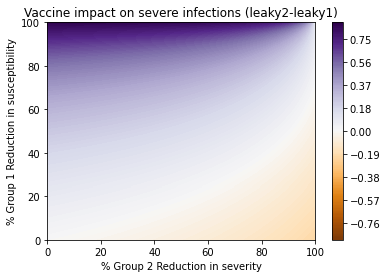

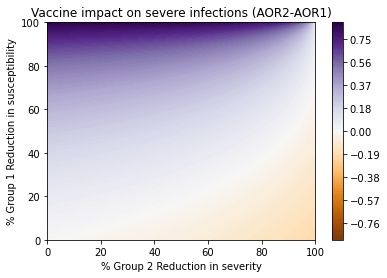

In [5]:
X, Y = np.meshgrid(severe_red, n_list)

indx = 0

# Difference in relative reduction in # infected between vaccinating group 2 and group 1 as compared to the no vax case
Z1 = (severe_size_leaky_1[indx,:,:] - severe_size_leaky_2[indx,:,:])/severe_size_no_vax[indx,:,:]

Z2 = (severe_size_AON_1[indx,:,:] - severe_size_AON_2[indx,:,:])/severe_size_no_vax[indx,:,:]

# Difference in relative reduction in # infected between vaccinating group 1 across the two strategies. (AON-leaky)
Z3 = (severe_size_leaky_1[indx,:,:] - severe_size_AON_1[indx,:,:])/severe_size_no_vax[indx,:,:]

# Difference in relative reduction in # infected between vaccinating group 2 across the two strategies. (AON-leaky)
Z4= (severe_size_leaky_2[indx,:,:] - severe_size_AON_2[indx,:,:])/severe_size_no_vax[indx,:,:]

# Defining custom bounds such that we can compare between the two color maps
bounds = np.arange(-0.9,0.9,0.01)

plot_customcolorbar(Z1,X,Y,severe_red,1,'% Group 2 Reduction in severity','% Group 1 Reduction in susceptibility','Vaccine impact on severe infections (leaky2-leaky1)',bounds=bounds)
plot_customcolorbar(Z2,X,Y,severe_red,1,'% Group 2 Reduction in severity','% Group 1 Reduction in susceptibility','Vaccine impact on severe infections (AON2-AON1)',bounds=bounds)

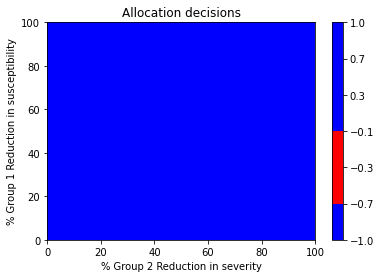

In [6]:
# Identifiying parameter space where the difference between the two decisions is highlighted

Z1_decisions = Z1.copy()
Z2_decisions = Z2.copy()

threshold_diff = 0.01 # Threshold for vaccine impact under which it doesn't matter which group is vaccinated. 

vax_2_leaky=np.where(Z1_decisions>threshold_diff)
vax_1_leaky=np.where(Z1_decisions<-threshold_diff)
vax_same_leaky_2 = np.where((Z1_decisions>=0)&(Z1_decisions<=threshold_diff))
vax_same_leaky_1 = np.where((Z1_decisions>=-threshold_diff)&(Z1_decisions<0))

vax_2_AON=np.where(Z2_decisions>threshold_diff)
vax_1_AON=np.where(Z2_decisions<-threshold_diff)
vax_same_AON_2 = np.where((Z2_decisions>=0)&(Z2_decisions<=threshold_diff))
vax_same_AON_1 = np.where((Z2_decisions>=-threshold_diff)&(Z2_decisions<0))

Z1_decisions[vax_2_leaky] = 1
Z1_decisions[vax_1_leaky] = -1
Z1_decisions[vax_same_leaky_2] = 2
Z1_decisions[vax_same_leaky_1] = -2

Z2_decisions[vax_2_AON] = 1
Z2_decisions[vax_1_AON] = -1
Z2_decisions[vax_same_AON_2] = 2
Z2_decisions[vax_same_AON_1] = -2

diff_decisions = (Z1_decisions * Z2_decisions)/4

bounds = np.arange(-1,1,0.01)
plot_customcolorbar(diff_decisions,X,Y,m_list,1,'% Group 2 Reduction in severity','% Group 1 Reduction in susceptibility','Allocation decisions',levels=True,bounds=bounds)

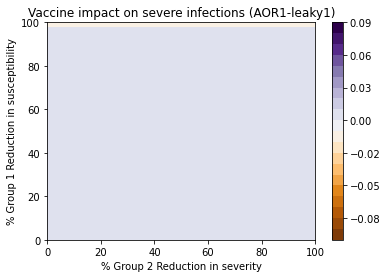

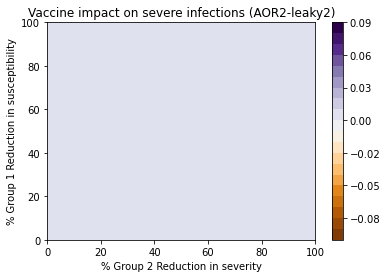

In [7]:
bounds = np.arange(-0.1,0.1,0.01)

plot_customcolorbar(Z3,X,Y,severe_red,1,'% Group 2 Reduction in severity','% Group 1 Reduction in susceptibility','Vaccine impact on severe infections (AON1-leaky1)',bounds=bounds)
plot_customcolorbar(Z4,X,Y,severe_red,1,'% Group 2 Reduction in severity','% Group 1 Reduction in susceptibility','Vaccine impact on severe infections (AON2-leaky2)',bounds=bounds)

#### R0 = 2

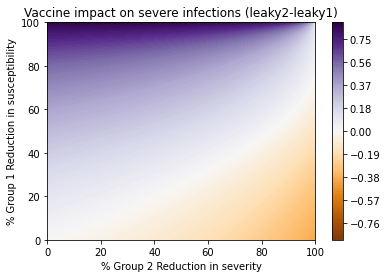

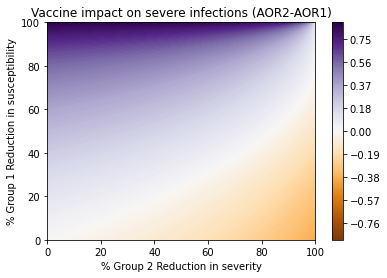

In [8]:
X, Y = np.meshgrid(severe_red, n_list)

indx = 1

# Difference in relative reduction in # infected between vaccinating group 2 and group 1 as compared to the no vax case
Z1 = (severe_size_leaky_1[indx,:,:] - severe_size_leaky_2[indx,:,:])/severe_size_no_vax[indx,:,:]

Z2 = (severe_size_AON_1[indx,:,:] - severe_size_AON_2[indx,:,:])/severe_size_no_vax[indx,:,:]

# Difference in relative reduction in # infected between vaccinating group 1 across the two strategies. (AON-leaky)
Z3 = (severe_size_leaky_1[indx,:,:] - severe_size_AON_1[indx,:,:])/severe_size_no_vax[indx,:,:]

# Difference in relative reduction in # infected between vaccinating group 2 across the two strategies. (AON-leaky)
Z4= (severe_size_leaky_2[indx,:,:] - severe_size_AON_2[indx,:,:])/severe_size_no_vax[indx,:,:]

# Defining custom bounds such that we can compare between the two color maps
bounds = np.arange(-0.9,0.9,0.01)

plot_customcolorbar(Z1,X,Y,severe_red,1,'% Group 2 Reduction in severity','% Group 1 Reduction in susceptibility','Vaccine impact on severe infections (leaky2-leaky1)',bounds=bounds)
plot_customcolorbar(Z2,X,Y,severe_red,1,'% Group 2 Reduction in severity','% Group 1 Reduction in susceptibility','Vaccine impact on severe infections (AON2-AON1)',bounds=bounds)

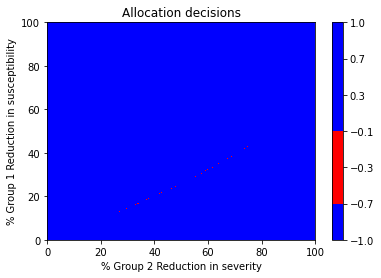

In [9]:
# Identifiying parameter space where the difference between the two decisions is highlighted

Z1_decisions = Z1.copy()
Z2_decisions = Z2.copy()

threshold_diff = 0.01 # Threshold for vaccine impact under which it doesn't matter which group is vaccinated. 

vax_2_leaky=np.where(Z1_decisions>threshold_diff)
vax_1_leaky=np.where(Z1_decisions<-threshold_diff)
vax_same_leaky_2 = np.where((Z1_decisions>=0)&(Z1_decisions<=threshold_diff))
vax_same_leaky_1 = np.where((Z1_decisions>=-threshold_diff)&(Z1_decisions<0))

vax_2_AON=np.where(Z2_decisions>threshold_diff)
vax_1_AON=np.where(Z2_decisions<-threshold_diff)
vax_same_AON_2 = np.where((Z2_decisions>=0)&(Z2_decisions<=threshold_diff))
vax_same_AON_1 = np.where((Z2_decisions>=-threshold_diff)&(Z2_decisions<0))

Z1_decisions[vax_2_leaky] = 1
Z1_decisions[vax_1_leaky] = -1
Z1_decisions[vax_same_leaky_2] = 2
Z1_decisions[vax_same_leaky_1] = -2

Z2_decisions[vax_2_AON] = 1
Z2_decisions[vax_1_AON] = -1
Z2_decisions[vax_same_AON_2] = 2
Z2_decisions[vax_same_AON_1] = -2

diff_decisions = (Z1_decisions * Z2_decisions)/4

bounds = np.arange(-1,1,0.01)
plot_customcolorbar(diff_decisions,X,Y,m_list,1,'% Group 2 Reduction in severity','% Group 1 Reduction in susceptibility','Allocation decisions',levels=True,bounds=bounds)

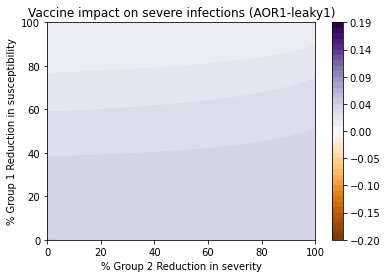

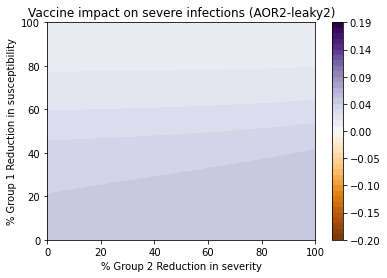

In [10]:
bounds = np.arange(-0.2,0.2,0.01)

plot_customcolorbar(Z3,X,Y,severe_red,1,'% Group 2 Reduction in severity','% Group 1 Reduction in susceptibility','Vaccine impact on severe infections (AON1-leaky1)',bounds=bounds)
plot_customcolorbar(Z4,X,Y,severe_red,1,'% Group 2 Reduction in severity','% Group 1 Reduction in susceptibility','Vaccine impact on severe infections (AON2-leaky2)',bounds=bounds)

#### R0 = 3

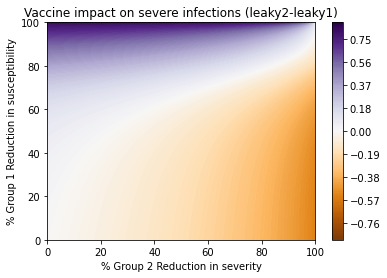

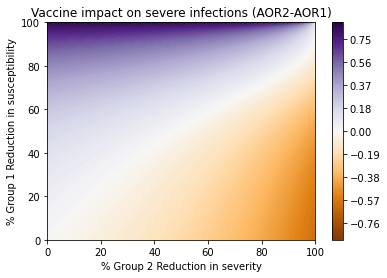

In [11]:
X, Y = np.meshgrid(severe_red, n_list)

indx = 2

# Difference in relative reduction in # infected between vaccinating group 2 and group 1 as compared to the no vax case
Z1 = (severe_size_leaky_1[indx,:,:] - severe_size_leaky_2[indx,:,:])/severe_size_no_vax[indx,:,:]

Z2 = (severe_size_AON_1[indx,:,:] - severe_size_AON_2[indx,:,:])/severe_size_no_vax[indx,:,:]

# Difference in relative reduction in # infected between vaccinating group 1 across the two strategies. (AON-leaky)
Z3 = (severe_size_leaky_1[indx,:,:] - severe_size_AON_1[indx,:,:])/severe_size_no_vax[indx,:,:]

# Difference in relative reduction in # infected between vaccinating group 2 across the two strategies. (AON-leaky)
Z4= (severe_size_leaky_2[indx,:,:] - severe_size_AON_2[indx,:,:])/severe_size_no_vax[indx,:,:]

# Defining custom bounds such that we can compare between the two color maps
bounds = np.arange(-0.9,0.9,0.01)

plot_customcolorbar(Z1,X,Y,severe_red,1,'% Group 2 Reduction in severity','% Group 1 Reduction in susceptibility','Vaccine impact on severe infections (leaky2-leaky1)',bounds=bounds)
plot_customcolorbar(Z2,X,Y,severe_red,1,'% Group 2 Reduction in severity','% Group 1 Reduction in susceptibility','Vaccine impact on severe infections (AON2-AON1)',bounds=bounds)

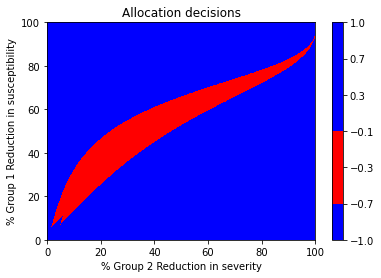

In [12]:
# Identifiying parameter space where the difference between the two decisions is highlighted

Z1_decisions = Z1.copy()
Z2_decisions = Z2.copy()

threshold_diff = 0.01 # Threshold for vaccine impact under which it doesn't matter which group is vaccinated. 

vax_2_leaky=np.where(Z1_decisions>threshold_diff)
vax_1_leaky=np.where(Z1_decisions<-threshold_diff)
vax_same_leaky_2 = np.where((Z1_decisions>=0)&(Z1_decisions<=threshold_diff))
vax_same_leaky_1 = np.where((Z1_decisions>=-threshold_diff)&(Z1_decisions<0))

vax_2_AON=np.where(Z2_decisions>threshold_diff)
vax_1_AON=np.where(Z2_decisions<-threshold_diff)
vax_same_AON_2 = np.where((Z2_decisions>=0)&(Z2_decisions<=threshold_diff))
vax_same_AON_1 = np.where((Z2_decisions>=-threshold_diff)&(Z2_decisions<0))

Z1_decisions[vax_2_leaky] = 1
Z1_decisions[vax_1_leaky] = -1
Z1_decisions[vax_same_leaky_2] = 2
Z1_decisions[vax_same_leaky_1] = -2

Z2_decisions[vax_2_AON] = 1
Z2_decisions[vax_1_AON] = -1
Z2_decisions[vax_same_AON_2] = 2
Z2_decisions[vax_same_AON_1] = -2

diff_decisions = (Z1_decisions * Z2_decisions)/4

bounds = np.arange(-1,1,0.01)
plot_customcolorbar(diff_decisions,X,Y,m_list,1,'% Group 2 Reduction in severity','% Group 1 Reduction in susceptibility','Allocation decisions',levels=True,bounds=bounds)

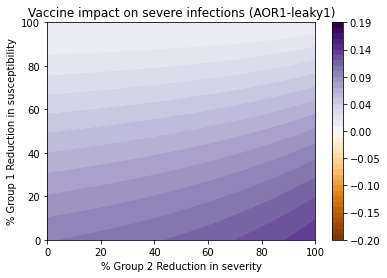

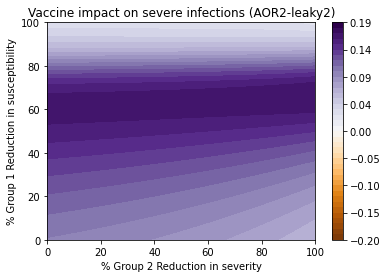

In [13]:
bounds = np.arange(-0.2,0.2,0.01)

plot_customcolorbar(Z3,X,Y,severe_red,1,'% Group 2 Reduction in severity','% Group 1 Reduction in susceptibility','Vaccine impact on severe infections (AON1-leaky1)',bounds=bounds)
plot_customcolorbar(Z4,X,Y,severe_red,1,'% Group 2 Reduction in severity','% Group 1 Reduction in susceptibility','Vaccine impact on severe infections (AON2-leaky2)',bounds=bounds)